# Object Detection on Clothing Dataset with YOLO (v5) using PyTorch

In this notebook we will learn how to finetune a pretrained YOLO (v5) model for detecting and classifying cloths from images.

The steps we are going to follow, are:

- Install required libraries
- Load clothing dataset
- Visualize images and annotations
- Convert to YOLO format
- About YOLO
- Fine-tune YOLO
- Evaluate YOLO
- Look at some predictions

This notebook is highly based on a [relevant post](https://curiousily.com/posts/object-detection-on-custom-dataset-with-yolo-v5-using-pytorch-and-python/) of [Venelin's blog](https://curiousily.com/). Have a look at this! It is really worth it!

In [68]:
!pip3 install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install numpy
!pip3 install PyYAML
!pip3 install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with

## Import required libraries

In [2]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

np.random.seed(42)

## Load Clothing Dataset

The dataset we choose to use contains annotations for clothing items - bounding boxes around shirts, tops, jackets, sunglasses, etc. 

This dataset can be found [here](https://www.kaggle.com/dataturks/clothing-item-detection-for-ecommerce).

It contains a single JSON file with URLs to all images and bounding box data. 
Download it, rename it to ```clothing.json``` and place it in the same directory.

In [69]:
clothing = []

with open("clothing.json") as f:
    for line in f:
        clothing.append(json.loads(line))

FileNotFoundError: [Errno 2] No such file or directory: 'clothing.json'

Let's have a look on an example annotation:

In [13]:
clothing[0]

{'annotation': [{'imageHeight': 312,
   'imageWidth': 147,
   'label': ['Tops'],
   'notes': '',
   'points': [{'x': 0.02040816326530612, 'y': 0.2532051282051282},
    {'x': 0.9931972789115646, 'y': 0.8108974358974359}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb063ad2b650163b00a1ead0017/4bb8fd9d-8d52-46c7-aa2a-9c18af10aed6___Data_xxl-top-4437-jolliy-original-imaekasxahykhd3t.jpeg',
 'extras': None}

The annotation contains: image dimensions, label, notes, bounding box points (normalized in 0-1 range) and an URL to the image file.

Let's find out if we have images with multiple annotations:

In [15]:
for c in clothing:
  if len(c['annotation']) > 1:
    display(c)

{'annotation': [{'imageHeight': 312,
   'imageWidth': 265,
   'label': ['Jackets'],
   'notes': '',
   'points': [{'x': 0, 'y': 0.6185897435897436},
    {'x': 0.026415094339622643, 'y': 0.6185897435897436}]},
  {'imageHeight': 312,
   'imageWidth': 265,
   'label': ['Skirts'],
   'notes': '',
   'points': [{'x': 0.01509433962264151, 'y': 0.03205128205128205},
    {'x': 1, 'y': 0.9839743589743589}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb063ad2b650163b00a1ead0017/b3be330c-c211-45bb-b244-11aef08021c8___Data_free-sk-5108-mudrika-original-imaf4fz626pegq9f.jpeg',
 'extras': None}

Let's get all the unique categories:

In [23]:
categories = []

for c in clothing:
    for a in c['annotation']:
        categories.extend(a['label'])
categories = list(set(categories))
categories.sort()
print(categories)

['Jackets', 'Jeans', 'Shirts', 'Shoes', 'Skirts', 'Tops', 'Trousers', 'Tshirts', 'sunglasses']


We have 9 different categories. Let's split the data into training and validation set:

In [24]:
train_clothing, val_clothing = train_test_split(clothing, test_size=0.1)

len(train_clothing), len(val_clothing)

(453, 51)

## Visualize images and annotations

Let's first download a sample image:

In [34]:
sample = train_clothing[10]

img = urllib.request.urlopen(sample['content'])
img = Image.open(img)
img = img.convert('RGB')

img.save('demo_image.jpeg', 'JPEG')

Here’s how our sample's annotation looks like:

In [35]:
sample

{'annotation': [{'imageHeight': 312,
   'imageWidth': 145,
   'label': ['Tops'],
   'notes': '',
   'points': [{'x': 0.013793103448275862, 'y': 0.22756410256410256},
    {'x': 1, 'y': 0.7948717948717948}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb063ad2b650163b00a1ead0017/ec339ad6-6b73-406a-8971-f7ea35d47577___Data_s-top-203-red-srw-original-imaf2nfrxdzvhh3k.jpeg',
 'extras': None}

Let's use OpenCV to read the image:

In [36]:
img = cv2.cvtColor(cv2.imread(f'demo_image.jpeg'), cv2.COLOR_BGR2RGB)
img.shape

(312, 145, 3)

Let’s add the bounding box on top of the image along with the label:

In [39]:
for a in sample['annotation']:
    for label in a['label']:
        w = a['imageWidth']
        h = a['imageHeight']
        points = a['points']
        p1, p2 = points
        x1, y1 = p1['x'] * w, p1['y'] * h
        x2, y2 = p2['x'] * w, p2['y'] * h
        cv2.rectangle(
            img,
            (int(x1), int(y1)),
            (int(x2), int(y2)),
            color=(0, 255, 0),
            thickness=2
        )
        
        ((label_width, label_height), _) = cv2.getTextSize(
            label,
            fontFace=cv2.FONT_HERSHEY_PLAIN,
            fontScale=1.75,
            thickness=2
        )
        
        cv2.rectangle(
            img,
            (int(x1), int(y1)),
            (int(x1 + label_width + label_width * 0.05), int(y1 + label_height + label_height * 0.25)),
            color=(0, 255, 0),
            thickness=cv2.FILLED
        )
        
        cv2.putText(
            img,
            label,
            org=(int(x1), int(y1 + label_height + label_height * 0.25)), # bottom left
            fontFace=cv2.FONT_HERSHEY_PLAIN,
            fontScale=1.75,
            color=(255, 255, 255),
            thickness=2
        )

The point coordinates are converted back to pixels and used to draw rectangles over the image. Here’s the result:

(-0.5, 144.5, 311.5, -0.5)

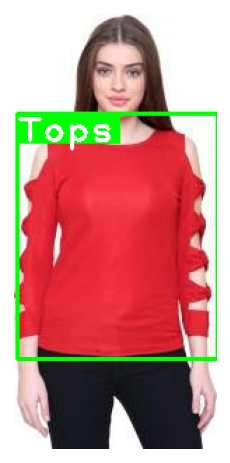

In [42]:
plt.imshow(img)
plt.axis('off')

## Convert to YOLO format

YOLO (v5) requires the dataset to be in the darknet format. Here’s an outline of what it looks like:

- One txt with labels file per image
- One row per object
- Each row contains: class_index bbox_x_center bbox_y_center bbox_width bbox_height
- Box coordinates must be normalized between 0 and 1

Let’s create a helper function that builds a dataset in the correct format for us:

In [44]:
def create_dataset(clothing, categories, dataset_type):
    
    images_path = Path(f"clothing/images/{dataset_type}")
    images_path.mkdir(parents=True, exist_ok=True)
    
    labels_path = Path(f"clothing/labels/{dataset_type}")
    labels_path.mkdir(parents=True, exist_ok=True)
    
    for img_id, row in enumerate(tqdm(clothing)):
        
        image_name = f"{img_id}.jpeg"
        
        img = urllib.request.urlopen(row["content"])
        img = Image.open(img)
        img = img.convert("RGB")
        
        img.save(str(images_path / image_name), "JPEG")
        
        label_name = f"{img_id}.txt"
        
        with (labels_path / label_name).open(mode="w") as label_file:
            
            for a in row['annotation']:
                for label in a['label']:
                    category_idx = categories.index(label)
                    points = a['points']
                    p1, p2 = points
                    x1, y1 = p1['x'], p1['y']
                    x2, y2 = p2['x'], p2['y']
                    bbox_width = x2 - x1
                    bbox_height = y2 - y1
                    label_file.write(
                        f"{category_idx} {x1 + bbox_width / 2} {y1 + bbox_height / 2} {bbox_width} {bbox_height}\n"
                    )

We’ll use it to create the train and validation datasets:

In [45]:
create_dataset(train_clothing, categories, 'train')
create_dataset(val_clothing, categories, 'val')

100%|██████████| 51/51 [01:10<00:00,  1.39s/it]


## About YOLO

The YOLO abbreviation stands for You Only Look Once. YOLO models are **one-stage** object detectors.

<img src="https://curiousily.com/static/155d6e43d137b4d481e47bda694bf16b/3e3fe/object-detection-models.png">

One-stage vs two-stage object detectors. Image from the YOLO v4 paper

YOLO models are very light and fastand are highly used in [real-time object detection](https://paperswithcode.com/sota/real-time-object-detection-on-coco).

Joseph Redmon introduced YOLO v1 in the 2016 paper [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/pdf/1506.02640.pdf). The implementation uses the [Darknet Neural Networks] library(https://pjreddie.com/darknet/).

Joseph Redmo also co-authored the YOLO v2 paper in 2017 [ YOLO9000: Better, Faster, Stronger](https://arxiv.org/pdf/1612.08242.pdf). A significant improvement over the first iteration with much better localization of objects.

His final shot was in the 2018 with the YOLO v3 paper [YOLOv3: An Incremental Improvement](https://arxiv.org/pdf/1804.02767.pdf).

Alexey Bochkovskiy published [YOLOv4: Optimal Speed and Accuracy of Object Detection](https://arxiv.org/abs/2004.10934) on April 23, 2020. The project has an [open-source repository](https://github.com/AlexeyAB/darknet) on GitHub.

YOLO v5 got open-sourced on May 30, 2020 by [Glenn Jocher](https://github.com/glenn-jocher) from ultralytics. There is no published paper, but the [complete project](https://github.com/ultralytics/yolov5) is on GitHub.

## YOLO v5 setup

Clone the repository:

In [61]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 3221 (delta 23), reused 25 (delta 8), pack-reused 3165
Receiving objects: 100% (3221/3221), 6.50 MiB | 1.40 MiB/s, done.
Resolving deltas: 100% (2138/2138), done.


In [51]:
%cd yolov5

/mnt/c/Users/bill/desktop/my/my_code/object_detection_with_yolo/yolov5


Now, we need to download the configuration file ```clothing.yaml``` from [here](https://drive.google.com/uc?id=1ZycPS5Ft_0vlfgHnLsfvZPhcH6qOAqBO) and place it in ```yolov5/data``` directory.

In case you cannot download it, you can also create it: The ```clothing.yaml``` file should be like this:

***train: ../clothing/images/train/***

***val: ../clothing/images/val/***

***nc: 9****

***names:
  [
    "Jackets",
    "Jeans",
    "Shirts",
    "Shoes",
    "Skirts",
    "Tops",
    "Trousers",
    "Tshirts",
    "sunglasses",
  ]***

## Training

We'll now fine-tune the YOLO v5 model.

The arguments passed are:

- '--img 640':   resize the images to 640x640 pixels
- '--batch 4':   use 4 images per batch
- '--epochs 30': train for 30 epochs
- '--data ./data/clothing.yaml': path to dataset config file
- '--cfg ./models/yolov5x.yaml': path to model config file
- '--weights yolov5x.pt': use pre-trained weights from the YOLOv5x model
- '--name yolov5x_clothing': name of our model
- '--cache': cache dataset images for faster training

In [65]:
!python3 train.py --img 640 --batch 4 --epochs 30 --data ./data/clothing.yaml --cfg ./models/yolov5x.yaml --weights yolov5x.pt --name yolov5x_clothing --cache

Your branch is behind 'origin/master' by 3 commits, and can be fast-forwarded.
  (use "git pull" to update your local branch)

Using torch 1.6.0+cpu CPU

Namespace(adam=False, batch_size=4, bucket='', cache_images=True, cfg='./models/yolov5x.yaml', data='./data/clothing.yaml', device='', epochs=30, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[640, 640], local_rank=-1, log_imgs=16, multi_scale=False, name='yolov5x_clothing', noautoanchor=False, nosave=False, notest=False, project='runs/train', rect=False, resume=False, save_dir='runs/train/yolov5x_clothing4', single_cls=False, sync_bn=False, total_batch_size=4, weights='yolov5x.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 0.05, 'cls': 0.5, 'cls_p

After training, the best checkpoint is saved to ```weights/best_yolo5x_clothing.pt```.

## Evaluation

AssertionError: No results.txt files found in /mnt/c/Users/bill/desktop/my/my_code/object_detection_with_yolo/yolov5, nothing to plot.

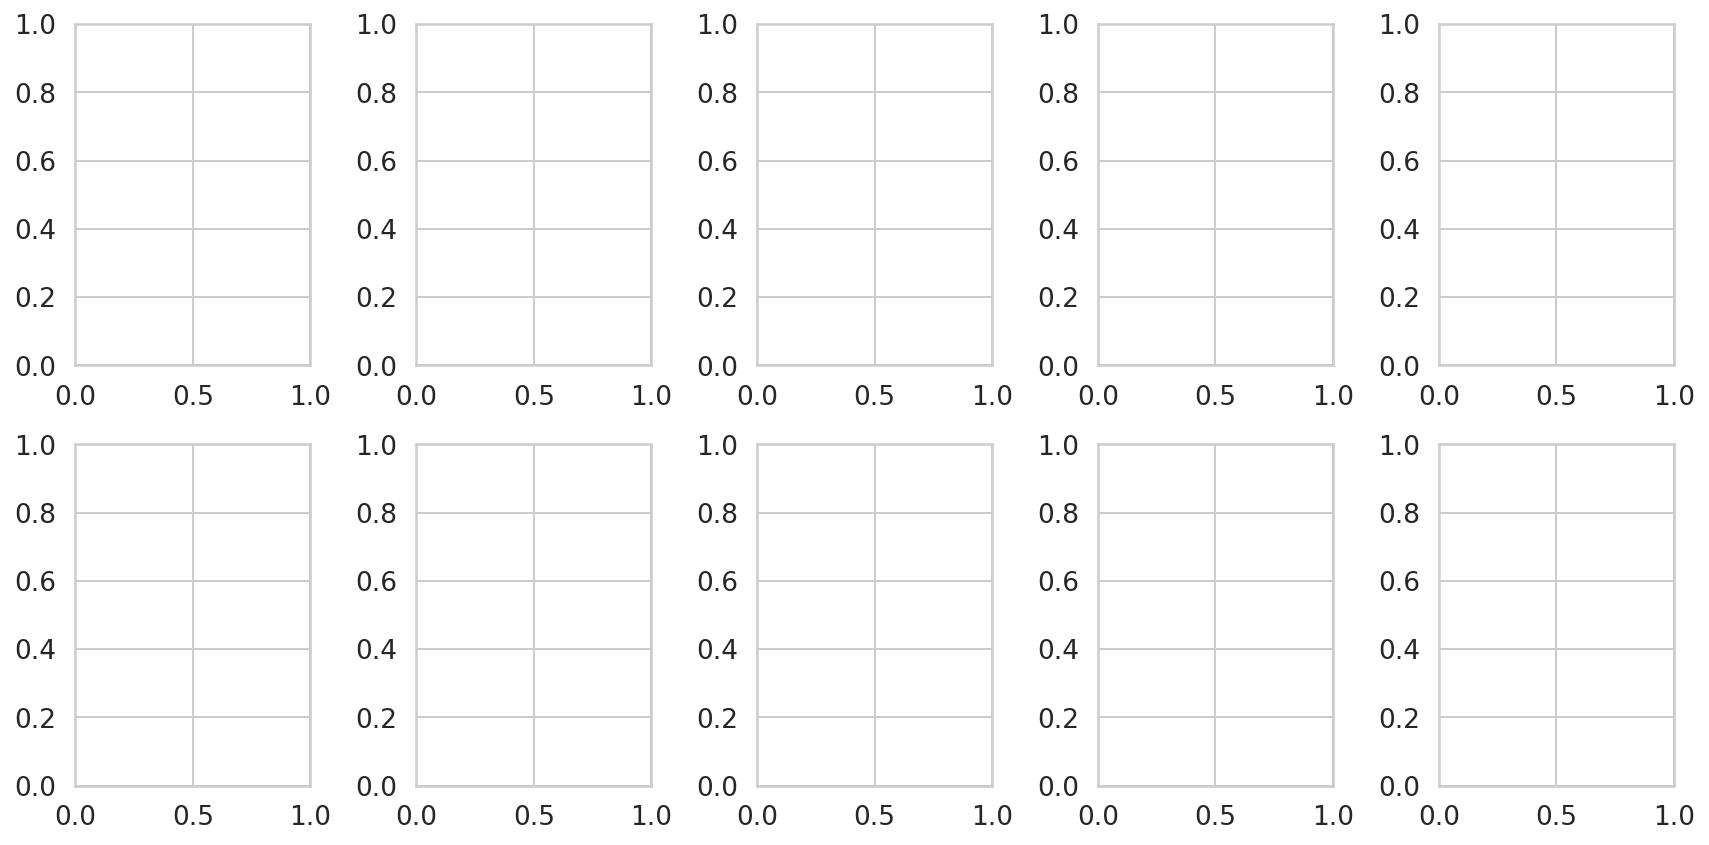

In [72]:
from utils.plots import plot_results

plot_results()

## Making predictions

Let’s pick 50 images from the validation set and move them to ```inference/images``` to see how our model does on those:

In [87]:
!mkdir ../inference
!mkdir ../inference/images
!find ../clothing/images/val/ -maxdepth 1 -type f | head -50 | xargs cp -t "../inference/images/"

mkdir: cannot create directory ‘../inference’: File exists
mkdir: cannot create directory ‘../inference/images’: File exists


We’ll use the ```detect.py``` script to run our model on those images. Here are the parameters we’re using:

- '--weights weights/best_yolov5x_clothing.pt': checkpoint of the model
- '--img 640': resize the images to 640x640 pixels
- '--conf 0.4': take into account predictions with confidence of 0.4 or higher
- '--source ./inference/images/': path to the images

In [88]:
!python3 detect.py --weights weights/best_yolov5x_clothing.pt --img 640 --conf 0.4 --source ../inference/images/

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='./inference/images/', update=False, view_img=False, weights=['weights/best_yolov5x_clothing.pt'])
Using torch 1.6.0+cpu CPU

Traceback (most recent call last):
  File "detect.py", line 173, in <module>
    detect()
  File "detect.py", line 33, in detect
    model = attempt_load(weights, map_location=device)  # load FP32 model
  File "/mnt/c/Users/bill/desktop/my/my_code/object_detection_with_yolo/yolov5/models/experimental.py", line 137, in attempt_load
    model.append(torch.load(w, map_location=map_location)['model'].float().fuse().eval())  # load FP32 model
  File "/home/dragon/.local/lib/python3.6/site-packages/torch/serialization.py", line 571, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/home/dragon/.local/lib/python3.6/site-packages/torch/serialization.

We'll also write a helper function to show the results:

In [90]:
def load_image(img_path: Path, resize=True):
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 256), interpolation = cv2.INTER_AREA)
    
    return img

def show_grid(image_paths):
    images = [load_image(img) for img in image_paths]
    images = torch.as_tensor(images)
    images = images.permute(0, 3, 1, 2)
    grid_img = torchvision.utils.make_grid(images, nrow=11)
    plt.figure(figsize=(24, 12))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

Here are the images along with the detected clothing:

In [91]:
img_paths = list(Path("inference/output").glob("*.jpeg"))[:22]
show_grid(img_paths)

RuntimeError: number of dims don't match in permute